# Problem

**State space.**
The states are encoded as integers
$$\mathcal{X} = {0,1,\dots,8} $$
corresponding to the grid in row-major order (top-left corner to bottom-right corner). State $8$ is the terminal goal state and is absorbing.

**Action space.**
Actions are represented as integers

$$ \mathcal{A} = {0,1,2,3} $$

where $0 =$ Up, $1 =$ Down, $2 =$ Left, $3 =$ Right.

**Transition dynamics.**
Transitions are deterministic. For any state $x$ and action $a$, the state index is first mapped to its grid coordinates $(r,c)$, the action moves the agent one step (unless this would leave the grid), and the result is mapped back to a state index. The goal state $8$ always transitions to itself.
The transition matrix $P$ has shape $(|\mathcal{X}||\mathcal{A}|) \times |\mathcal{X}| = 36 \times 9$, where each row corresponds to a pair $(x,a)$ and contains a one-hot vector indicating the unique next state:

$$P[(x,a),x'] = 1 \quad \text{iff } x' = \text{next\_state}(x,a)$$

and $0$ otherwise.

**Reward model.**
Thus $r(x,a) = 1$ only when $x$ is the goal state, and $0$ otherwise.

**Initial state.**
The initial state is fixed as $x_0 = 0$.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))

from fogas import FOGASSolver, FOGASOracleSolver, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver

# Tabular Features

## Definition

### Description

**Feature Map**

We use a tabular one-hot feature representation over state–action pairs.
Each feature corresponds to a unique \((x,a)\) combination.

The feature map is defined as:
$$
\phi(x,a) \in \mathbb{R}^{36}
$$
with the ordering
$$
(x,a) \;\longrightarrow\; e_{\,x \cdot |\mathcal{A}| + a}
\quad |\mathcal{A}| = 4
$$

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{36}$ is defined as:
$$
\omega_i =
\begin{cases}
1 & \text{if } i \in \{8\cdot 4,\, 8\cdot 4 + 1,\, 8\cdot 4 + 2,\, 8\cdot 4 + 3\}, \\
0 & \text{otherwise}.
\end{cases}
$$

This yields:
$$
r(x,a) =
\begin{cases}
1 & \text{if } x = 8 \;\;(\text{goal state}), \\
0 & \text{otherwise}.
\end{cases}
$$

**Transition Weights**

For each $x' \in \mathcal{X}$,
$$
\psi(x')_i =
\begin{cases}
1 & \text{if } i = 4x + a \text{ and } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$

Equivalently, stacking $\psi(x')$ for all $x'$ recovers the tabular
transition matrix
$$
P \in \mathbb{R}^{36 \times 9}
$$
where each row $(x,a)$ contains a single 1 at the column corresponding
to $\text{next\_state}(x,a)$.

The terminal goal state $x = 8$ is absorbing, so for all actions $a$,
$$
\text{next\_state}(8,a) = 8
$$


## Testing

In [10]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state
dataset_path = "/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/grid3_problem.csv" # path where to download the dataset

goal_grid = 8   # absorbing terminal state

def phi(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

omega = np.zeros(N*A)
omega[8 * A : 8* A + 4] = 1

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

def next_state(s, a):
    if s == goal_grid:
        return goal_grid  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

def psi(xp):
    v = np.zeros(N * A)
    for x in states:
        for a in actions:
            if next_state(x, a) == xp:
                v[x * A + a] = 1.0
    return v

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, psi=psi)

### Oracle

In [5]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=600)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                600   (overridden → 600)

FOGAS Hyperparameters
---------------------
alpha:                        0.001133
rho:                            5.820702
eta:                            0.000022
D_theta:                    18.973666
beta (ridge):             0.000046
D_pi (derived):           12.897881





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1785
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=1.1330e-03, rho=1.0000e-02, eta=3.8644e-02 | metric = -0.4633

Optimizing rho
[After rho*] alpha=1.1330e-03, rho=1.0000e-03, eta=3.8644e-02 | metric = -0.4636

Optimizing alpha
[After alpha*] alpha=1.4537e-01, rho=1.0000e-03, eta=3.8644e-02 | metric = -0.6561


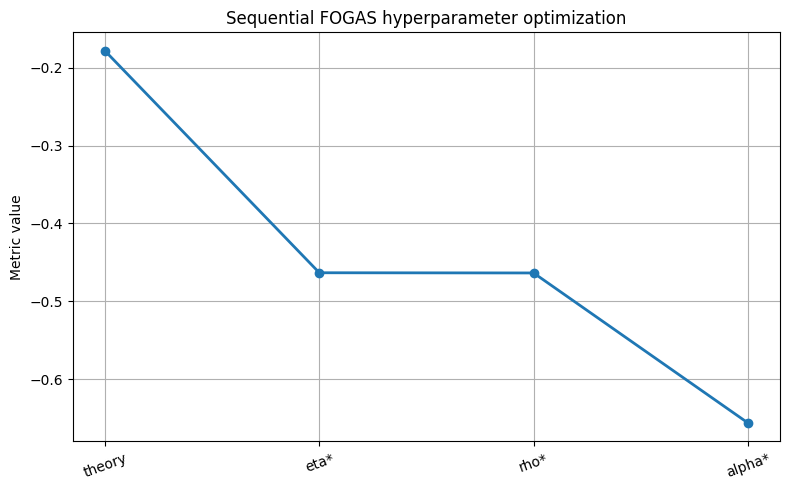

In [6]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [8]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS:   0%|          | 0/600 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 600/600 [00:00<00:00, 3732.30it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 2.175584e-15
||Q^π - Q*||_2 = 4.351168e-15




### Empirical

In [11]:
solver_e = FOGASSolver(mdp=mdp, print_params=True, csv_path=dataset_path)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           150
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      138.8269278958555
T (iterations):                139

FOGAS Hyperparameters
---------------------
alpha:                        0.002354
rho:                            1389.672495
eta:                            0.000045
D_theta:                    18.973666
beta (ridge):             0.000200
D_pi (derived):           6.207977




Trying same optimal hyperparameters found for the oracle.

In [12]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/139 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 139/139 [00:02<00:00, 64.74it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 1.782774e+00
||Q^π - Q*||_2 = 3.187866e+00



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 0.656100
J(π_FOGAS) = 0.593233
Gap (J* − J) = 6.286688e-02




Try again first eta, end alpha


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1843
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=2.3539e-03, rho=1.3897e+03, eta=1.0000e+00 | metric = -0.1844

Optimizing rho
[After rho*] alpha=2.3539e-03, rho=4.8367e+01, eta=1.0000e+00 | metric = -0.2081

Optimizing alpha
[After alpha*] alpha=4.5194e+00, rho=4.8367e+01, eta=1.0000e+00 | metric = -0.4974


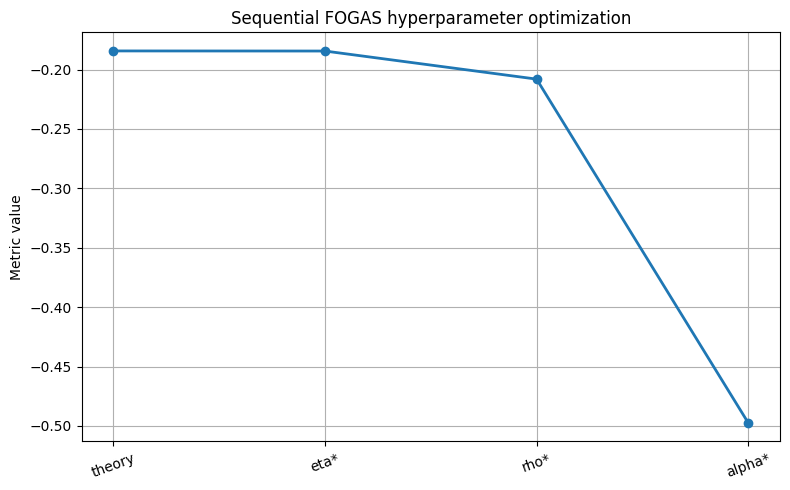

In [ ]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [14]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 139/139 [00:01<00:00, 70.29it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 6.875598e+00
||Q^π - Q*||_2 = 1.206157e+01



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 0.656100
J(π_FOGAS) = 0.497426
Gap (J* − J) = 1.586735e-01




Try now first alpha and finally eta (CONVERGES).


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1843
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.8105e+00, rho=1.3897e+03, eta=4.5343e-05 | metric = -0.2529

Optimizing rho
[After rho*] alpha=4.8105e+00, rho=2.1227e-02, eta=4.5343e-05 | metric = -0.2728

Optimizing eta
[After eta*] alpha=4.8105e+00, rho=2.1227e-02, eta=4.9312e-02 | metric = -0.6561


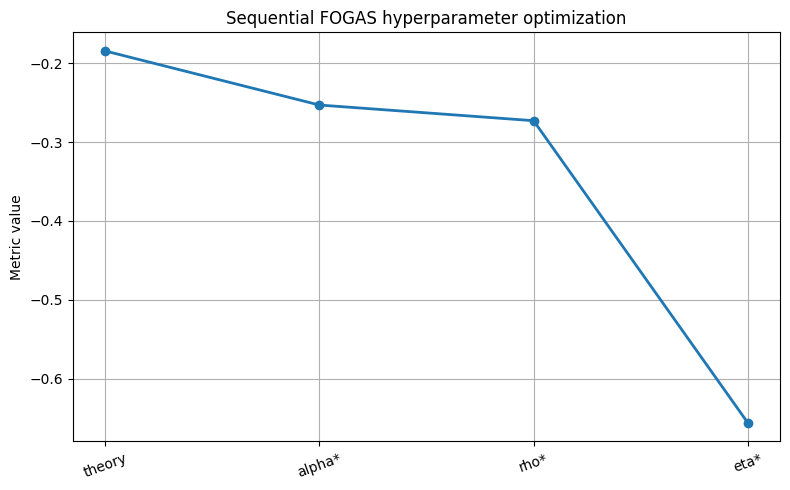

In [15]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [16]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 139/139 [00:02<00:00, 65.80it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 3.180105e-07
||Q^π - Q*||_2 = 5.724092e-07



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 0.656100
J(π_FOGAS) = 0.656100
Gap (J* − J) = 2.802600e-10




# State-aggregation Features

We did two different state-aggregation features, showing that if the feature of the action with the feature of the state are not mixed, the algorithm will not converge (the policy is completely independent of the state).

## 1 - Definition (FAILED)

**Feature Map**

We use a structured linear feature representation over state–action pairs that decomposes into row features, action features, and a terminal indicator.

The state space is a (3 \times 3) grid with
$$
\mathcal{X} = {0,\dots,8}, \quad \mathcal{A} = {0,1,2,3}.
$$

Let $ \text{row}(x) \in \{0,1,2\}$ denote the row index of state (x).
The feature map is defined as
$$
\phi(x,a) \in \mathbb{R}^{d}, \qquad d = 3 + 4 + 1 = 8.
$$

It has the following structure:
$$
\phi(x,a) =
\begin{bmatrix}
\mathbf{1}{\text{row}(x)=0} \\
\mathbf{1}{\text{row}(x)=1} \\
\mathbf{1}{\text{row}(x)=2} \\
\mathbf{1}{a=0} \\
\mathbf{1}{a=1} \\
\mathbf{1}{a=2} \\
\mathbf{1}{a=3} \\
\mathbf{1}{x = 8}
\end{bmatrix}.
$$

Thus:

* The **first 3 coordinates** encode the row of the grid.
* The **next 4 coordinates** encode the chosen action.
* The **last coordinate** is a terminal-state indicator for the goal state (x=8).

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{8}$ is defined as
$$
\omega =
\begin{bmatrix}
0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 1
\end{bmatrix}.
$$

This yields:
$$
r(x,a) =
\begin{cases}
1 & \text{if } x = 8 \;\; (\text{goal state}), \\
0 & \text{otherwise}.
\end{cases}
$$

**Transition Model**

The transition matrix
$$
P \in \mathbb{R}^{(9\cdot 4) \times 9}
$$
is defined such that each row corresponding to $(x,a)$ contains a single 1 at column $x'$:

$$
P_{(x,a),x'} =
\begin{cases}
1 & \text{if } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$


## Testing

In [3]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state
dataset_path = "/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/grid3_problem.csv" # path where to download the dataset

goal = 8   # absorbing terminal state

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

d = N // 3 + A + 1
def phi(state, action):
    r, _ = to_rc(state)

    feature = np.zeros(d)
    feature[r] = 1.0
    feature[(N // 3) + action] = 1.0
    feature[d - 1] = 1.0 if state == goal else 0

    return feature

omega = np.zeros(d)
omega[d - 1] = 1.0

def next_state(s, a):
    if s == goal:
        return goal  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

P_grid = np.zeros((N * A, N))
count = 0
for x in range(N):
    for a in range(A):
        xp = next_state(x, a)     # deterministic next state
        for xp_ in range(N):
            if xp_ == xp:
                P_grid[count, xp_] = 1.0
            else:
                P_grid[count, xp_] = 0.0
        count += 1

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P_grid)

### Oracle

In [4]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=1000)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.7321
Num states N:             9
Num actions A:            4
Feature dim d:            8
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      27765385.5791711
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.001075
rho:                            1.325841
eta:                            0.000044
D_theta:                    8.944272
beta (ridge):             0.000375
D_pi (derived):           9.613513





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1925
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
alpha=0.001074823381273985, metric=-0.19246001316396977
alpha=0.001676372067506085, metric=-0.1935248360701738
alpha=0.0026145907854960068, metric=-0.19417800693524712
alpha=0.004077904367477665, metric=-0.19454817948879172
alpha=0.0063601937720203245, metric=-0.1947614166914646
alpha=0.009919816938391625, metric=-0.1948887215456557
alpha=0.015471661967925154, metric=-0.19496666693864198
alpha=0.024130719905054318, metric=-0.1950151772253615
alpha=0.03763601120185756, metric=-0.19504568925959523
alpha=0.05869983758295003, metric=-0.1950650123875835
alpha=0.09155250044390062, metric=-0.19507730370597606
alpha=0.14279188295343795, metric=-0.1950851443582753
alpha=0.22270851957650412, metric=-0.19509015505868055
alpha=0.3473522700735836, metric=-0.19509336098648672
alpha=0.5417556533297555, metric=-0.19509541373528008
alpha=0.8449611912787413, metric=-0.09153492669434064
a

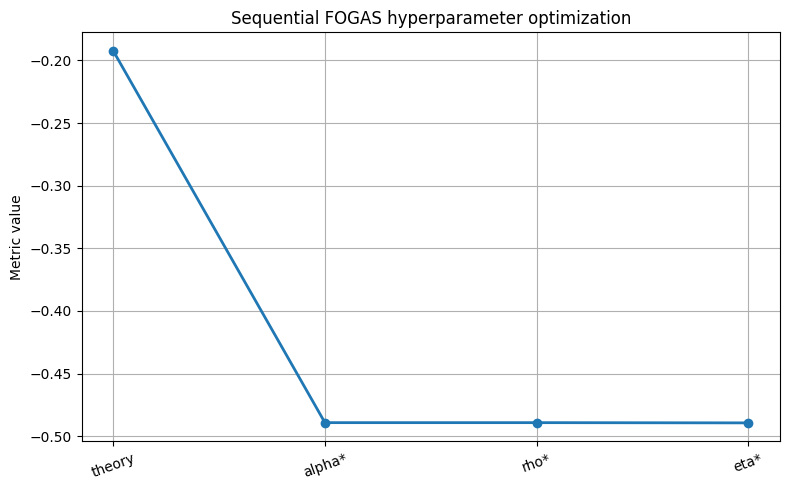

In [9]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    print_search=True,
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [12]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, verbose=True, print_policies=True)
evaluator.compare_value_functions()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 2
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 2
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 2
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 2
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 2
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


[FOGAS] Iter 1/1000
  θ_t     =

NOT CONVERGING BECAUSE INDEPENDENT OF THE STATE.

## 2 - DEFINITION (CONVERGES)

**Feature Map**

We use a structured linear feature representation over state–action pairs that decomposes into row features, action features, and a terminal indicator.

The state space is a (3 \times 3) grid with
$$
\mathcal{X} = {0,\dots,8}, \quad \mathcal{A} = {0,1,2,3}.
$$

Let $ \text{row}(x) \in \{0,1,2\}$ denote the row index of state (x).
The feature map is defined as
$$
\phi(x,a) \in \mathbb{R}^{d}, \qquad d = 3 * 4 + 1 = 13.
$$

It has the following structure:
$$
\phi(x,a): \; \; (x,a) \;\longrightarrow\; e_{\; \text{row}(x) \; \cdot \; |\mathcal{A}|\; + \; a},
$$

Thus:

* The **first 3 coordinates** encode the row of the grid.
* The **next 4 coordinates** encode the chosen action.
* The **last coordinate** is a terminal-state indicator for the goal state (x=8).

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{8}$ is defined as
$$
\omega =
\begin{bmatrix}
0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 1
\end{bmatrix}.
$$

This yields:
$$
r(x,a) =
\begin{cases}
1 & \text{if } x = 8 \;\; (\text{goal state}), \\
0 & \text{otherwise}.
\end{cases}
$$

**Transition Model**

The transition matrix
$$
P \in \mathbb{R}^{(9\cdot 4) \times 9}
$$
is defined such that each row corresponding to $(x,a)$ contains a single 1 at column $x'$:

$$
P_{(x,a),x'} =
\begin{cases}
1 & \text{if } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$


## Testing

In [13]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state
dataset_path = "/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/grid3_problem.csv" # path where to download the dataset

goal = 8   # absorbing terminal state

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

d = (N // 3) * A + 1   # 3*4 + 1 = 13

def phi(state, action):
    r, _ = to_rc(state)
    f = np.zeros(d)
    f[r * A + action] = 1.0
    f[-1] = 1.0 if state == goal else 0.0
    return f

omega = np.zeros(d)
omega[d - 1] = 1.0

def next_state(s, a):
    if s == goal:
        return goal  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

P_grid = np.zeros((N * A, N))
count = 0
for x in range(N):
    for a in range(A):
        xp = next_state(x, a)     # deterministic next state
        for xp_ in range(N):
            if xp_ == xp:
                P_grid[count, xp_] = 1.0
            else:
                P_grid[count, xp_] = 0.0
        count += 1

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P_grid)

### Oracle

In [14]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=1000)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            13
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510257.052780736
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.001033
rho:                            2.154492
eta:                            0.000033
D_theta:                    11.401754
beta (ridge):             0.000154
D_pi (derived):           11.774100





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1548
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
alpha=0.001032656902259667, metric=-0.15484768924901626
alpha=0.0016140023210955766, metric=-0.14872925706809517
alpha=0.0025226224574702587, metric=-0.14401742986924737
alpha=0.003942760168159914, metric=-0.14077314129140256
alpha=0.006162379827228541, metric=-0.1385915897968597
alpha=0.009631558480706716, metric=-0.1371118809489778
alpha=0.0150537489359844, metric=-0.13611274525997988
alpha=0.023528420398587838, metric=-0.1354465880132215
alpha=0.036774000204652935, metric=-0.13500781227063113
alpha=0.05747632302306958, metric=-0.13472150786296638
alpha=0.08983324332048734, metric=-0.13453593088139662
alpha=0.14040584332854372, metric=-0.13441618497604618
alpha=0.21944883778123223, metric=-0.13433914795870908
alpha=0.3429899444487248, metric=-0.13428968383244627
alpha=0.536079858897299, metric=-0.14866523304996948
alpha=0.8378718378384122, metric=-0.15728189945131582


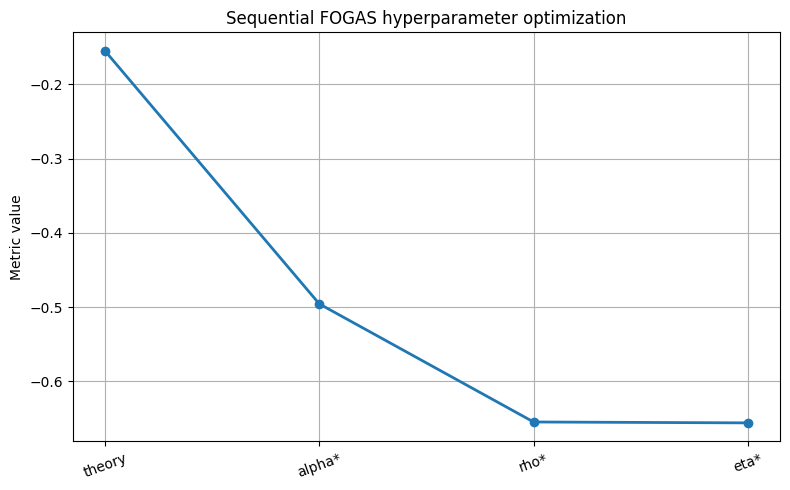

In [15]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    print_search=True,
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [17]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, verbose=True, print_policies=True)
evaluator.compare_value_functions()
evaluator.print_policy()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 3
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 3
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 3
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


[FOGAS] Iter 1/1000
  θ_t     =

### Empirical

In [25]:
solver_e = FOGASSolver(mdp=mdp, print_params=True, csv_path=dataset_path, T=400)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           150
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            13
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      277.65385579171107
T (iterations):                400   (overridden → 400)

FOGAS Hyperparameters
---------------------
alpha:                        0.001633
rho:                            531.692601
eta:                            0.000052
D_theta:                    11.401754
beta (ridge):             0.000385
D_pi (derived):           7.446595




Trying same optimal hyperparameters found for the oracle.

In [26]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/400 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 400/400 [00:06<00:00, 57.44it/s]



========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 1.651233e+01
||Q^π - Q*||_2 = 2.859512e+01



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 0.656100
J(π_FOGAS) = 0.080314
Gap (J* − J) = 5.757855e-01




Try again first eta, end alpha


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1911
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=5.5169e-01, rho=5.3169e+02, eta=5.2340e-05 | metric = -0.3188

Optimizing rho
[After rho*] alpha=5.5169e-01, rho=1.0000e-02, eta=5.2340e-05 | metric = -0.3271

Optimizing eta
[After eta*] alpha=5.5169e-01, rho=1.0000e-02, eta=3.4248e-02 | metric = -0.5810


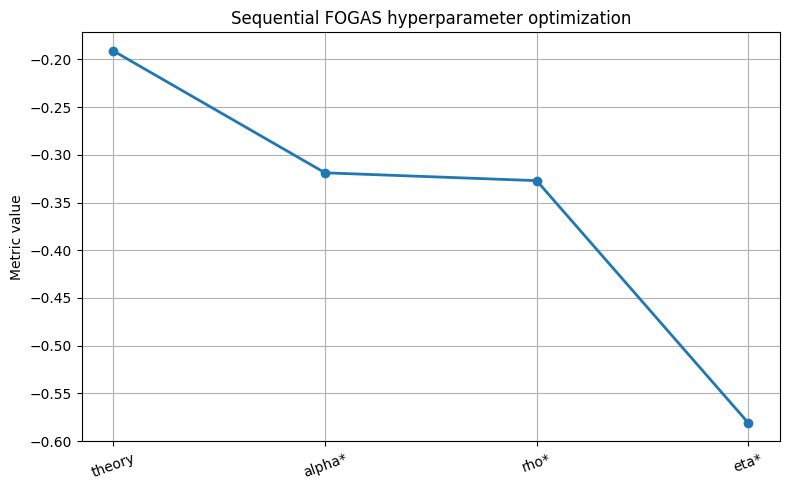

In [27]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=1,
    order=("alpha", "rho", "eta")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [28]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 400/400 [00:07<00:00, 52.34it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 1.660294e+00
||Q^π - Q*||_2 = 2.951744e+00



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 0.656100
J(π_FOGAS) = 0.580990
Gap (J* − J) = 7.510954e-02




# Funky Features (FAILED)

## Definition

**Feature map.**
We use $d = 5$ features. The feature vector for $(x,a)$ is

$$ \phi(x,a) = [1, \text{row}(x), \text{col}(x), a, \mathbf{1}_{x = 8}] $$

where $\text{row}(x) = x \; // \; 3$ and $\text{col}(x) = x \; \% \; 3$. The last component is a goal indicator.

**Reward model.**
Rewards are linear in $\phi(x,a)$:
$ r(x,a) = \phi(x,a)^\top \omega $
with

$$ \omega = [0, 0, 0, 0, 1] $$

Thus $r(x,a) = 1$ only when $x$ is the goal state, and $0$ otherwise.

**Transition weights**
Not defined.

**Initial state.**
The initial state is fixed as $x_0 = 0$.

## Testing

In [18]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state
dataset_path = "/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/grid3_problem.csv" # path where to download the dataset

goal = 8   # absorbing terminal state

def phi(state, action):
    is_goal = float(state == goal_grid)
    return np.array([1.0, float(state // 3), float(state % 3), float(action), is_goal])

omega = np.array([0, 0, 0, 0, 1.0]) 

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

def next_state(s, a):
    if s == goal_grid:
        return goal_grid  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

P_grid = np.zeros((N * A, N))
count = 0
for x in range(N):
    for a in range(A):
        xp = next_state(x, a)     # deterministic next state
        for xp_ in range(N):
            if xp_ == xp:
                P_grid[count, xp_] = 1.0
            else:
                P_grid[count, xp_] = 0.0
        count += 1

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P_grid)

### Oracle

In [25]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=1000)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     4.3589
Num states N:             9
Num actions A:            4
Feature dim d:            5
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      175847442.001417
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000540
rho:                            0.828651
eta:                            0.000028
D_theta:                    7.071068
beta (ridge):             0.003800
D_pi (derived):           3.820023





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.0006
Order: ('rho', 'eta', 'alpha')

Optimizing rho
[After rho*] alpha=5.4023e-04, rho=1.0000e-03, eta=2.7924e-05 | metric = -0.0006

Optimizing eta
[After eta*] alpha=5.4023e-04, rho=1.0000e-03, eta=1.0000e+00 | metric = -0.2167

Optimizing alpha
[After alpha*] alpha=1.3433e-03, rho=1.0000e-03, eta=1.0000e+00 | metric = -0.2375


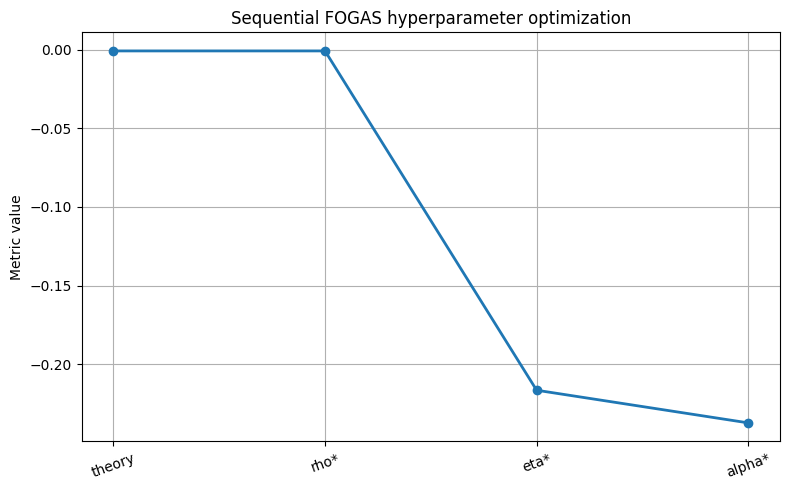

In [26]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("rho", "eta", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [30]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, print_policies=True, T = 2000)
# evaluator.compare_value_functions()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


Iteration 201
  State 0: π(a=0|

<function fogas.algorithm.fogas_oraclesolver.FOGASOracleSolver.softmax_policy.<locals>.pi(x)>